# Building a Recommender System with Amazon SageMaker Factorization Machines and BlazingText

---

---

## Background

- Recommender systems were a catalyst for ML's popularity (Amazon, Netflix Prize)
- User item matrix factorization is a core methodology
- Factorization machines combine linear prediction with a factorized representation of pairwise feature interaction

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

- SageMaker has a highly scalable factorization machines algorithm built-in

---

## Setup

1. Spin up SageMaker hosted notebook instance in console
2. Add SageMaker IAM policy to this SageMaker notebook to allow S3 read/write access
3. Instantiate S3 bucket (first code cell)
4. Import necessary libraries (second code cell)

In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
base = 'DEMO-loft-recommender'
prefix = 'sagemaker/' + base

role = sagemaker.get_execution_role()

In [2]:
import sagemaker
import os
import pandas as pd
import numpy as np
import boto3
import json
import io
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from scipy.sparse import csr_matrix

---

## Data

[Amazon Reviews AWS Public Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)

Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

- 1 to 5 star ratings
- 2M+ Amazon customers
- 160K+ digital videos 

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [4]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

Drop some fields that won't be used

In [5]:
df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]

When you execute the following cell, you will see most users don't rate most movies. Check out the long tail.

For example of customers, upto 50 percentile (see 0.50 row), the count is 1. It means those users submitted only one review. Among 2 million unique users, more than a half submitted only one review. 


In [6]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers count\n', customers.size)
print('customers\n', customers.quantile(quantiles))

print('products count \n', products.size)
print('products\n', products.quantile(quantiles))

customers count
 2018155
customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products count 
 166034
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


In the following cell, filter out customers who haven't rated many movies

You will keep customers who submitted more than 5 reviews. You will also keep movies which received more than 10 reviews. 

By doing so, the customer count is now about 140K, and product count is about 38K. You can view that by entering customer_index and product_index in a separate cell and execute it in the subsequent cell.

The third line of code in the following cell saves customerId and productId as reduced_df in the memory.

In [7]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Create a sequential index for customers and movies

In [8]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

In [9]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0]) + customer_index.shape[0]})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,product_title,star_rating,review_date,user,item
0,27072354,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,10463,140451
1,16030865,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-06-20,489,140451
2,44025160,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-05-27,32100,140451
3,18602179,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2014-12-23,2237,140451
4,14424972,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,32340,140451


Count days since first review (included as a feature to capture trend)

In [12]:
reduced_df['review_date'] = pd.to_datetime(reduced_df['review_date'])
customer_first_date = reduced_df.groupby('customer_id')['review_date'].min().reset_index()
customer_first_date.columns = ['customer_id', 'first_review_date']

In [13]:
reduced_df = reduced_df.merge(customer_first_date)
reduced_df['days_since_first'] = (reduced_df['review_date'] - reduced_df['first_review_date']).dt.days
reduced_df['days_since_first'] = reduced_df['days_since_first'].fillna(0)

In [14]:
reduced_df

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first
0,27072354,B008LOVIIK,Masterpiece: Inspector Lewis Season 5,5,2015-08-31,10463,140451,2015-04-21,132.0
1,27072354,B003V8GGA6,Wallace & Gromit's Cracking Contraptions,5,2015-08-31,10463,144910,2015-04-21,132.0
2,27072354,B00SY9HO8U,Suburban Gothic,1,2015-07-22,10463,142596,2015-04-21,92.0
3,27072354,B008Y7EYSK,The Woman in Black,4,2015-07-22,10463,140711,2015-04-21,92.0
4,27072354,B0079W7X98,Masterpiece: Inspector Lewis Season 2,5,2015-06-16,10463,140411,2015-04-21,56.0
5,27072354,B004AVPV7C,Masterpiece: Inspector Lewis Season 3,5,2015-06-16,10463,140565,2015-04-21,56.0
6,27072354,B00NL5R7NO,Ken Burns: The Roosevelts - An Intimate Histor...,4,2015-05-18,10463,140475,2015-04-21,27.0
7,27072354,B001BWQ0XM,The X-Files Season 1,5,2015-05-18,10463,140813,2015-04-21,27.0
8,27072354,B005LAN0AG,"Masterpiece: Inspector Lewis, Season 4",4,2015-05-18,10463,140557,2015-04-21,27.0
9,27072354,B008VVET4S,Black Death,3,2015-05-18,10463,145900,2015-04-21,27.0


Split into train and test datasets

In [15]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

- Factorization machines expects data to look something like:
  - Sparse matrix
  - Target variable is that user's rating for a movie
  - One-hot encoding for users ($N$ features)
  - One-hot encoding for movies ($M$ features)

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|Feature1|Feature2|...|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|20|2.2|...|
|5|1|0|...|0|0|1|0|...|0|17|9.1|...|
|3|0|1|...|0|1|0|0|...|0|3|11.0|...|
|4|0|1|...|0|0|0|1|...|0|15|6.4|...|


- Wouldn't want to hold this full matrix in memory
  - Create a sparse matrix
  - Designed to work efficiently with CPUs. Some parts of training for more dense matrices can be parallelized with GPUs

In [16]:
def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items + 1
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                           df['days_since_first'].values])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim - 1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [17]:
train_csr = to_csr_matrix(train_df, customer_index.shape[0], product_index.shape[0])
test_csr = to_csr_matrix(test_df, customer_index.shape[0], product_index.shape[0])

In [18]:
train_csr.shape

(1028606, 178730)

Convert to sparse recordIO-wrapped protobuf that SageMaker factorization machines expects

In [19]:
def to_s3_protobuf(csr, label, bucket, prefix, channel='train', splits=10):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)
        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))

In [20]:
to_s3_protobuf(train_csr, train_df['star_rating'].values.astype(np.float32), bucket, prefix)
to_s3_protobuf(test_csr, test_df['star_rating'].values.astype(np.float32), bucket, prefix, channel='test', splits=1)

---

## Train

- Create a [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) estimator to run a training jobs and specify:
  - Algorithm container image
  - IAM role
  - Hardware setup
  - S3 output location
  - Algorithm hyperparameters
    - `feature_dim`: $N + M + 1$ (additional feature is `days_since_first` to capture trend). 𝑁=140344 (reduced number of customers). M=38385 (reduced number of movies).
    - `num_factors`: reduced dimension of factorized interactions
    - `epochs`: number of full passes through the dataset
- `.fit()` points to training and test data in S3 and begins the training job

In [21]:
fm = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'factorization-machines', 'latest'),
    role, 
    train_instance_count=4, 
    train_instance_type='ml.c5.2xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    base_job_name=base,
    sagemaker_session=sess)

fm.set_hyperparameters(
    feature_dim=customer_index.shape[0] + product_index.shape[0] + 1,
    predictor_type='regressor',
    mini_batch_size=1000,
    num_factors=256,
    epochs=2)

fm.fit({'train': sagemaker.s3_input('s3://{}/{}/train/'.format(bucket, prefix), distribution='ShardedByS3Key'), 
        'test': sagemaker.s3_input('s3://{}/{}/test/'.format(bucket, prefix), distribution='FullyReplicated')})

2019-11-14 20:10:48 Starting - Starting the training job...
2019-11-14 20:10:49 Starting - Launching requested ML instances......
2019-11-14 20:11:51 Starting - Preparing the instances for training......
2019-11-14 20:13:10 Downloading - Downloading input data
2019-11-14 20:13:10 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[11/14/2019 20:13:24 INFO 140560096048960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias


2019-11-14 20:13:23 Training - Training image download completed. Training in progress.[11/14/2019 20:13:35 INFO 139910269654848] Pulling entire model from kvstore to finalize
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 27.191162109375, "sum": 27.191162109375, "min": 27.191162109375}}, "EndTime": 1573762416.010271, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1573762413.376152}

[2019-11-14 20:13:36.011] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/test", "epoch": 0, "duration": 9814, "num_examples": 1, "num_bytes": 70668}
[2019-11-14 20:13:35.983] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 4, "duration": 3810, "num_examples": 309, "num_bytes": 21931124}
[11/14/2019 20:13:35 INFO 139786326951744] #quality_metric: host=algo-2, epoch=1, train rmse <loss>=1.22296500788
[11/14/2019 20:13:35 INFO 139786326951744] #quality_metric: host=algo-2, epo


2019-11-14 20:14:14 Uploading - Uploading generated training model
2019-11-14 20:14:14 Completed - Training job completed
Training seconds: 284
Billable seconds: 284


---

## Host

Deploy trained model to a real-time production endpoint

In [22]:
fm_predictor = fm.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

--------------------------------------------------------------------------------------!

Setup predictor to serialize in-memory data for invocation requests

In [23]:
def fm_serializer(df):
    feature_dim = customer_index.shape[0] + product_index.shape[0] + 1
    js = {'instances': []}
    for index, data in df.iterrows():
        js['instances'].append({'data': {'features': {'values': [1, 1, data['days_since_first']],
                                                      'keys': [data['user'], data['item'], feature_dim - 1],
                                                      'shape': [feature_dim]}}})
    return json.dumps(js)

In [24]:
fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

Real-time prediction for a single user item

In [25]:
test_df.head(1)

,customer_id,product_id,product_title,star_rating,review_date,user,item,first_review_date,days_since_first
0,10378,B002PZDM9Y,Ghosts of Girlfriends Past,4,2013-01-14,8644,174741,2012-12-28,17.0


In [26]:
fm_predictor.predict(test_df.head(1))

{'predictions': [{'score': 2.8365631103515625}]}

Clean-up the endpoint

In [27]:
fm_predictor.delete_endpoint()

---

---

# Extra credit

- What happens when a new movie is added?
  - No feature to set to "1" in the dataset
  - No previous ratings to find similar items
  - Cold start problem is hard with factorization machines
- Word2vec
  - Word embeddings for natural language processing (similar words get similar vectors)
  - Use concatenated product titles as words customer review history as sentences
  - SageMaker BlazingText is an extremely fast implementation that can work with subwords

---

## Data

Concatenate product titles to treat each one as a single word

In [28]:
reduced_df['product_title'] = reduced_df['product_title'].apply(lambda x: x.lower().replace(' ', '-'))

Write customer purchase histories

In [29]:
first = True
with open('customer_purchases.txt', 'w') as f:
    for customer, data in reduced_df.sort_values(['customer_id', 'review_date']).groupby('customer_id'):
        if first:
            first = False
        else:
            f.write('\n')
        f.write(' '.join(data['product_title'].tolist()))

Write to S3 so SageMaker training can use it

In [30]:
inputs = sess.upload_data('customer_purchases.txt', bucket, '{}/word2vec/train'.format(prefix))

---

## Train

Create a SageMaker estimator:
- Specify training job arguments
- Set hyperparameters
  - Remove titles that occur less than 5 times
  - Embed in a 100-dimensional subspace
  - Use subwords to capture similarity in titles
  - Skipgram is to use the current word to predict its neighbors (its context). While CBOW is to use each of those context to predict the current word. 

In [31]:
bt = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'blazingtext', 'latest'),
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p3.2xlarge',
    train_volume_size = 5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess)

bt.set_hyperparameters(mode="skipgram",
    epochs=10,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    min_char=5,
    max_char=10,
    evaluation=False,
    subwords=True)

bt.fit({'train': sagemaker.s3_input(inputs, distribution='FullyReplicated', content_type='text/plain')})

2019-11-14 21:02:17 Starting - Starting the training job...
2019-11-14 21:02:25 Starting - Launching requested ML instances......
2019-11-14 21:03:26 Starting - Preparing the instances for training......
2019-11-14 21:04:43 Downloading - Downloading input data
2019-11-14 21:04:43 Training - Downloading the training image...
2019-11-14 21:05:02 Training - Training image download completed. Training in progress.Arguments: train
[11/14/2019 21:05:02 WARNING 139664558516032] Loggers have already been setup.
[11/14/2019 21:05:02 WARNING 139664558516032] Loggers have already been setup.
[11/14/2019 21:05:02 INFO 139664558516032] nvidia-smi took: 0.0503211021423 secs to identify 1 gpus
[11/14/2019 21:05:02 INFO 139664558516032] Running BlazingText on singe GPU using skipgram
[11/14/2019 21:05:02 INFO 139664558516032] Processing /opt/ml/input/data/train/customer_purchases.txt . File size: 23 MB
Read 1M words
Number of words:  17990
Initialized GPU 0 successfully! Now starting training....
####

---

## Model

- Bring in and extract the model from S3
- Take a look at the embeddings

In [32]:
!aws s3 cp $bt.model_data ./

download: s3://sagemaker-us-west-2-601091450883/sagemaker/DEMO-loft-recommender/output/blazingtext-2019-11-14-21-02-17-432/output/model.tar.gz to ./model.tar.gz


In [33]:
!tar -xvzf model.tar.gz

vectors.txt
vectors.bin


In [34]:
vectors = pd.read_csv('vectors.txt', delimiter=' ', skiprows=2, header=None)

Do the embeddings appear to have meaning

In [35]:
vectors.sort_values(1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
643,teen-wolf-season-1,-1.17640,0.452430,1.092900,0.752500,0.643830,-0.080052,0.562590,-0.120290,0.438390,...,0.041892,0.224220,0.362890,0.945050,-0.216230,1.129400,0.374240,-0.021329,-0.118840,NaN
4420,power-rangers-samurai,-1.16110,0.015385,-0.017846,-0.091686,1.210800,0.206710,0.994860,0.180840,0.511250,...,0.461900,0.376410,-0.472560,0.357880,-0.092410,0.001698,-0.037554,-0.982650,-0.278610,NaN
998,teen-wolf-season-2,-1.11440,0.523500,1.069500,0.706690,0.722260,-0.185050,0.523550,-0.015499,0.493970,...,-0.026533,0.272770,0.354880,0.954740,-0.286990,1.218800,0.462200,-0.037070,-0.045387,NaN
856,teen-wolf-season-3-(part-1),-1.10850,0.337130,1.105800,0.735710,0.575680,-0.133060,0.562440,-0.056838,0.107920,...,-0.092998,0.477410,0.436970,0.975720,-0.193610,0.973840,0.477440,0.100190,0.084354,NaN
834,teen-wolf-season-4,-1.10020,0.604690,0.951410,0.877530,0.780410,-0.006246,0.517540,-0.063644,0.554130,...,-0.067130,0.358250,0.483270,1.043300,-0.258890,1.202200,0.475680,-0.062821,0.125220,NaN
417,doctor-who-season-1,-1.09320,0.336220,0.707300,-0.418980,0.707610,-0.170910,0.653350,-0.243000,-0.270180,...,0.054263,0.314080,-0.110060,0.459440,-0.638900,0.199340,0.568570,-0.224550,-0.398030,NaN
893,doctor-who-season-4,-1.09260,0.492020,0.611220,-0.423890,0.878150,-0.092045,0.701590,-0.196200,-0.170750,...,-0.012518,0.343760,-0.026837,0.592360,-0.734930,0.221800,0.639270,-0.230200,-0.169100,NaN
1046,doctor-who-season-6,-1.07720,0.505050,0.784390,-0.306720,0.773330,0.040374,0.440360,-0.273590,-0.034733,...,0.123610,0.484610,0.004675,0.740870,-0.513840,0.133680,0.629190,-0.206540,-0.378220,NaN
977,doctor-who-season-3,-1.05930,0.405150,0.750560,-0.610770,0.839890,-0.211850,0.664500,-0.219020,-0.232160,...,0.013690,0.383930,-0.086457,0.492610,-0.709260,0.197590,0.606890,-0.296260,-0.201030,NaN
686,doctor-who-season-2,-1.03290,0.423810,0.712050,-0.497690,0.784830,-0.271760,0.649200,-0.119290,-0.236880,...,0.013585,0.298900,-0.128220,0.442380,-0.684260,0.263430,0.602940,-0.241460,-0.316510,NaN


In [36]:
vectors.sort_values(2)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
538,black-or-white,0.542400,-1.00470,0.107550,0.193640,0.409920,0.244780,-0.388010,0.078686,0.095208,...,-0.110480,0.322530,0.694280,-0.225140,-0.381970,0.519300,-0.182940,-0.751310,-0.409590,NaN
16933,er-season-15,0.750510,-0.93356,0.520350,0.107620,0.431030,-0.046301,-0.378890,0.529580,0.659530,...,-0.900150,0.295400,0.978770,0.323830,-0.687220,0.623750,-0.292170,-0.519220,-0.369020,NaN
802,home-alone,-0.187080,-0.90052,-0.720470,0.227480,0.443170,0.185730,0.328030,0.476630,-0.499890,...,-0.153570,-0.742210,-0.132480,0.047511,-0.191690,0.861540,-0.135650,-0.714130,-0.446950,NaN
97,24-season-1,-0.188590,-0.87840,0.277900,0.291100,0.719920,-0.769630,0.224500,0.415150,-0.528050,...,0.568110,-0.081602,0.374080,-0.104490,0.065173,0.670170,0.165090,-0.491130,-0.176420,NaN
11862,person-of-interest,0.766300,-0.86979,0.692250,0.014835,-0.114350,-0.969040,-0.309180,-0.156300,0.185320,...,0.056929,0.047202,1.025300,-0.062409,0.133210,-0.772230,-0.234530,0.327590,-0.030652,NaN
15212,er-season-12,0.690420,-0.86700,0.229000,0.285330,0.388730,-0.343450,-0.244950,0.098043,0.380230,...,-0.852010,0.031159,1.023400,-0.126720,-0.494950,0.405380,-0.162260,-0.352530,-0.218550,NaN
2531,the-mentalist:-season-7,0.546410,-0.86415,0.956740,0.090460,0.160900,-0.074034,-0.256830,0.109260,0.322160,...,0.479760,-0.048532,0.074608,-0.008877,-0.230160,0.281240,0.158990,-0.672290,-0.487810,NaN
8535,the-tudors,0.002689,-0.85697,0.479770,0.153840,0.220860,-0.245240,-0.181630,0.210280,0.329980,...,-0.804040,-0.322330,-0.144080,0.544070,-0.499540,-0.759640,-0.138860,-0.198130,0.030807,NaN
562,ballykissangel-season-1,-0.200270,-0.85497,-0.891020,-0.420300,0.571520,-0.020480,0.000265,-0.045964,-0.428730,...,0.792880,-0.393570,0.111770,0.660520,-0.321860,0.255700,-0.795990,0.394700,-0.501650,NaN
6447,er-season-1,0.287580,-0.85157,0.244540,-0.353310,0.264720,-0.433610,-0.158230,0.219780,0.123320,...,-0.298230,-0.343740,0.379530,0.003118,-0.723910,0.364270,-0.412560,0.060363,-0.605650,NaN


Yes, but there's 100.  Let's reduce this further with t-SNE and map the top 100 titles.

In [37]:
product_titles = vectors[0]
vectors = vectors.drop([0, 101], axis=1)

t-SNE is a tool to visualize high-dimensional data. We will be using skit learn's implementation. 

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
embeddings = tsne.fit_transform(vectors.values[:100, ])

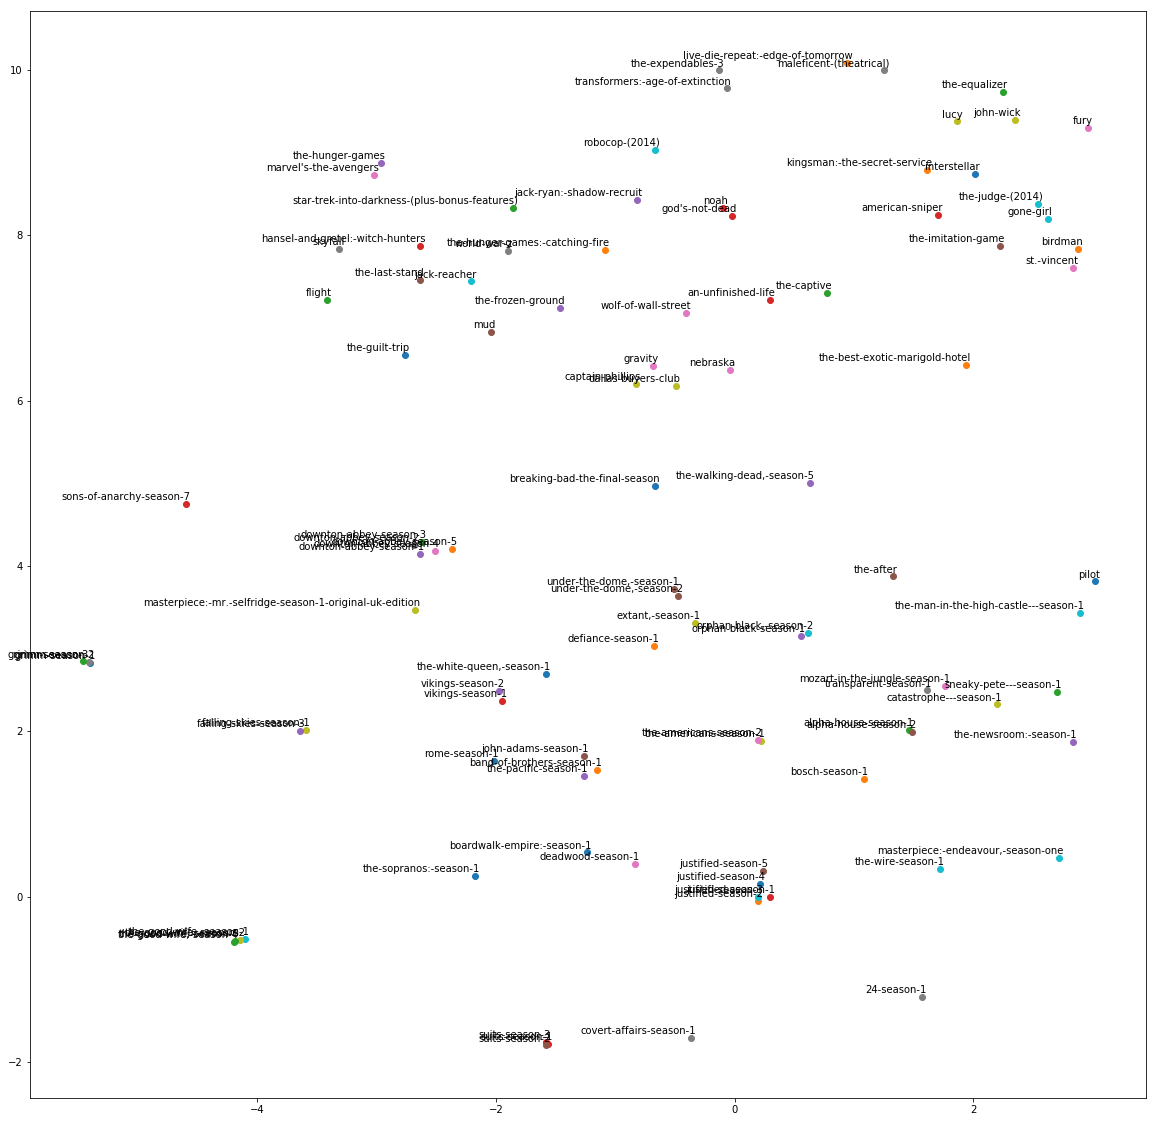

In [39]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(embeddings, product_titles[:100])

---

## Host

Deploy our model to a real-time endpoint.

In [40]:
bt_endpoint = bt.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------------------------!

Try generating predictions for a set of titles (some of which are real, some of which are made up).

In [41]:
words = ["sherlock-season-1", 
         "sherlock-season-2",
         "sherlock-season-5",
         'arbitrary-sherlock-holmes-string',
         'the-imitation-game',
         "abcdefghijklmn",
         "keeping-up-with-the-kardashians-season-1"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs_df = pd.DataFrame(json.loads(response))

Calculate correlation and distance.

In [42]:
vecs_df = pd.DataFrame(vecs_df['vector'].values.tolist(), index=vecs_df['word'])

In [43]:
vecs_df = vecs_df.transpose()
vecs_df.corr()

word,sherlock-season-1,sherlock-season-2,sherlock-season-5,arbitrary-sherlock-holmes-string,the-imitation-game,abcdefghijklmn,keeping-up-with-the-kardashians-season-1
word,,,,,,,
sherlock-season-1,1.000000,0.967437,0.926361,0.600720,0.289336,0.234479,0.161642
sherlock-season-2,0.967437,1.000000,0.932026,0.587547,0.251842,0.240229,0.181299
sherlock-season-5,0.926361,0.932026,1.000000,0.600377,0.333780,0.246690,0.220609
arbitrary-sherlock-holmes-string,0.600720,0.587547,0.600377,1.000000,0.366558,0.169251,-0.002570
the-imitation-game,0.289336,0.251842,0.333780,0.366558,1.000000,0.351256,0.149165
abcdefghijklmn,0.234479,0.240229,0.246690,0.169251,0.351256,1.000000,0.318891
keeping-up-with-the-kardashians-season-1,0.161642,0.181299,0.220609,-0.002570,0.149165,0.318891,1.000000


In [44]:
for column in vecs_df.columns:
    print(column + ':', np.sum((vecs_df[column] - vecs_df['sherlock-season-1']) ** 2))

sherlock-season-1: 0.0
sherlock-season-2: 0.765829724545631
sherlock-season-5: 1.68123785203154
arbitrary-sherlock-holmes-string: 7.782375135668285
the-imitation-game: 13.244357442304958
abcdefghijklmn: 11.505035589633339
keeping-up-with-the-kardashians-season-1: 20.463266309185638


Relative to 'sherlock-season-1':
- 'sherlock-season-5' is made up, but relates well with 'sherlock-season-1' and 'sherlock-season-2'
- 'arbitrary-sherlock-holmes-string' is also made up and relates less well but still fairly strong
- 'the-imitation-game' is another popular Prime video title starring Benedict Cumberbatch and has a moderate relationship, but worse than the arbitrary Sherlock title
- 'abcdefghijklmn' is made up and relates even worse
- 'keeping-up-with-the-kardashians-season-1' somehow manages to relate even worse

Clean-up the endpoint

In [45]:
bt_endpoint.delete_endpoint()

---

---

# Wrap-up

- Built a recommender system on a large dataset quickly and accurately
- Add more features to extend
- Compare to other methods
- Ensemble two models